<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_4_FACEBOOK_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROPHET (FACEBOOK)

https://thedatahero.com/resources-forecasting-models-and-time-series-for-business-in-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.model_selection import ParameterGrid

# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

## mount drive

In [3]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
# /content/drive/MyDrive/Colab Notebooks/Python-Time-Series-Forecasting/Modern Time Series Forecasting Techniques/Prophet
DATA_SUB_INTRO = "Modern Time Series Forecasting Techniques/Prophet"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%ls

drive/  sample_data/


In [6]:
# Daily Bike Sharing training.csv
df = pd.read_csv(DRIVE_DATASET_PATH + "Daily Bike Sharing training.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Preparing Data

In [9]:
# rename columns
df = df.rename(columns = {
    "cnt": "y",
    "dteday": "ds"
    })

# Change ds into YYYY-mm-dd
df["ds"] = pd.to_datetime(df["ds"], format="%m/%d/%Y")

df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [14]:
# Prepare the weather situation, make it categorical

weather_sit = pd.get_dummies(df["weathersit"], drop_first = True)
weather_sit

# concat weather_sit to df
df = pd.concat([df, weather_sit], axis = 1)
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,2,3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,False,False


In [16]:
# rename new columns named, 2 and 3
df = df.rename(columns = {
    2: "weathersit_2",
    3: "weathersit_3"
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       701 non-null    int64         
 1   ds            701 non-null    datetime64[ns]
 2   season        701 non-null    int64         
 3   yr            701 non-null    int64         
 4   mnth          701 non-null    int64         
 5   holiday       701 non-null    int64         
 6   weekday       701 non-null    int64         
 7   workingday    701 non-null    int64         
 8   weathersit    701 non-null    int64         
 9   temp          701 non-null    float64       
 10  atemp         701 non-null    float64       
 11  hum           701 non-null    float64       
 12  windspeed     701 non-null    float64       
 13  casual        701 non-null    int64         
 14  registered    701 non-null    int64         
 15  y             701 non-null    int64     

In [17]:
# Drop variables that are not needed
df.drop(
    columns = ["instant", "season", "yr", "mnth", "weekday", "casual", "registered"],
        axis = 1,
        inplace = True)
df.head()


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


# EDA

In [18]:
# Create a copy of the df with index
df_temp = df.copy()
df_temp.set_index("ds", inplace = True)
df_temp.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
ds,,,,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


In [20]:
df_temp.index
# freq = None

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq=None)

In [22]:
df_temp.index.freq = "D"
df_temp.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq='D')

# Data visualization

## Plot y values

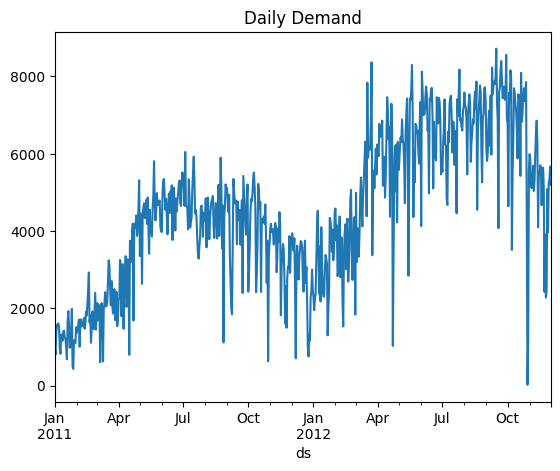

In [23]:
df_temp["y"].plot(title = "Daily Demand")
plt.show()
# There are some spikes (up and down)

## Monthly plot


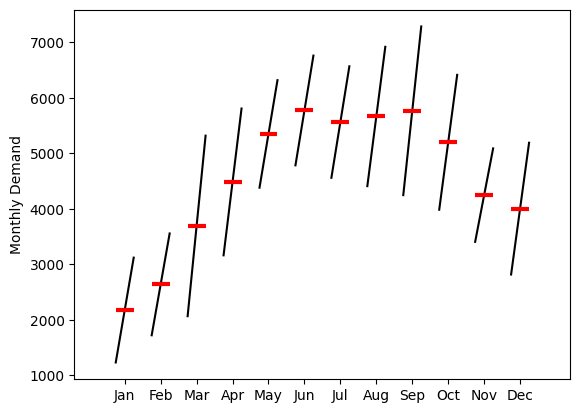

In [31]:
month_plot(df_temp["y"].resample("ME").mean(), ylabel="Monthly Demand")
plt.show()

## Quarterly plot

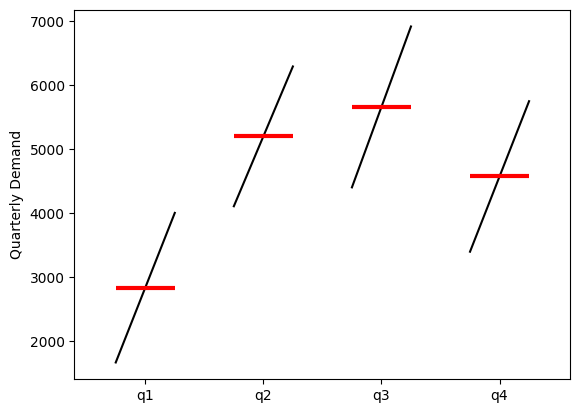

In [32]:
quarter_plot(df_temp["y"].resample("QE").mean(), ylabel="Quarterly Demand")
plt.show()

## Seasonal decomposition

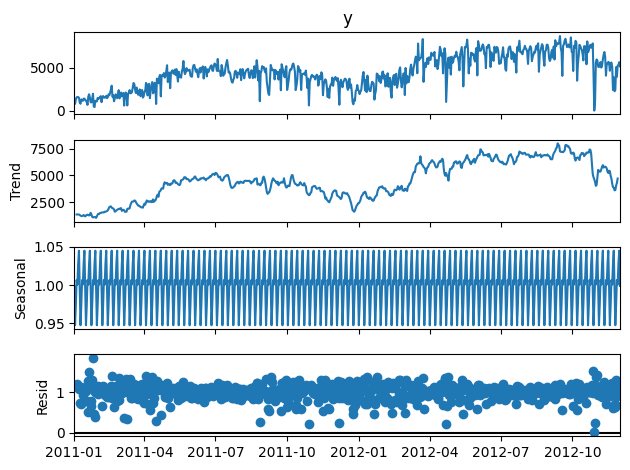

In [34]:
# plot seasonal decomposition
decomposition = seasonal_decompose(
    df_temp["y"],
    model = "mul",
    period = 7 # here we had used 365 before. But here we do not have 2 cycles!
    )

fig = decomposition.plot()
plt.show()
# We cannot get too much info from the plots

## Auto-correlation (correlation between daily data & lags)

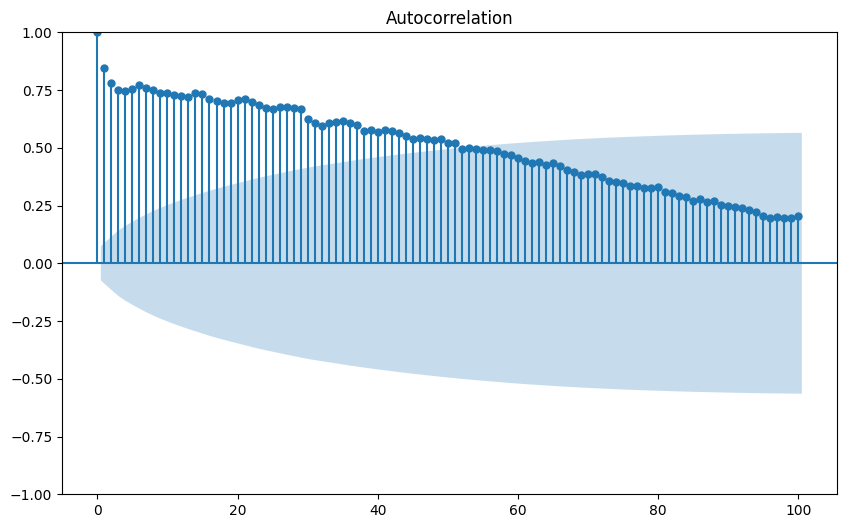

In [36]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(df_temp["y"], lags = 100, ax = ax)
plt.show()


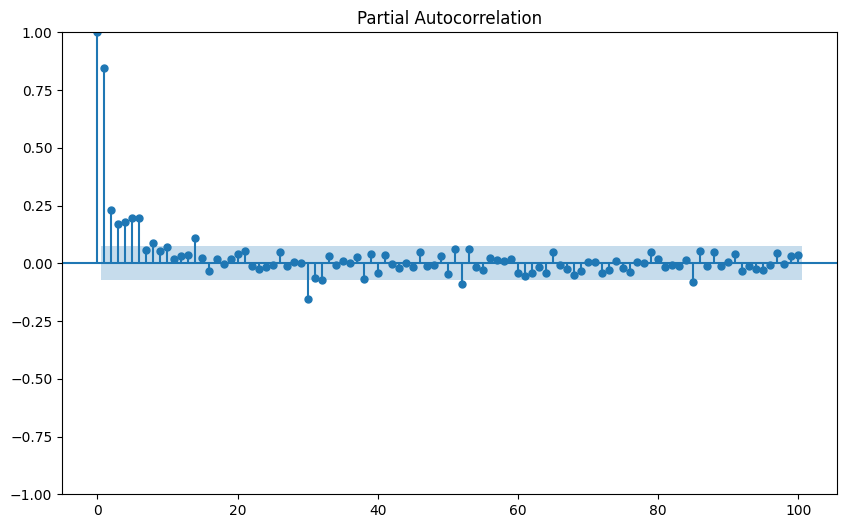

In [40]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(df_temp["y"], lags = 100, ax = ax)
plt.show()


# Dynamic holidays in Prophet